# Predicting First Stint Length in Formula 1 Races

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib
import pickle as pkl

In [16]:
try:
    tire_data = pd.read_csv('../eda/processed_first_stint_data.csv')
    weather_data = pd.read_csv('../eda/processed_weather_data.csv')
except FileNotFoundError as e:
    print(f"Error: {e}. Ensure 'processed_first_stint_data.csv' and 'processed_weather_data.csv' are available.")
    raise

merged_data = pd.merge(tire_data, weather_data, left_on=['Year', 'RoundNumber'], 
                       right_on=['year', 'round_num'], how='inner').drop(columns=['year', 'round_num'])

print("Missing values:\n", merged_data.isna().sum())

merged_data = merged_data.dropna()

merged_data.to_csv('merged_tire_weather_data.csv', index=False)
print("Merged data sample:\n", merged_data.head())

Missing values:
 Year                  0
RoundNumber           0
Driver                0
StartingCompound      0
StartingTyreLife      0
TyreLifeAtEnd         0
FirstStintLength      0
avg_air_temp          0
avg_humidity          0
avg_pressure          0
avg_rainfall          0
avg_track_temp        0
avg_wind_direction    0
avg_wind_speed        0
dtype: int64
Merged data sample:
    Year  RoundNumber Driver StartingCompound  StartingTyreLife  TyreLifeAtEnd  \
0  2022           14    ALB           MEDIUM               1.0           11.0   
1  2022           14    ALO           MEDIUM               1.0           12.0   
2  2022           14    BOT             SOFT               1.0            3.0   
3  2022           14    GAS           MEDIUM               1.0           11.0   
4  2022           14    HAM           MEDIUM               1.0            2.0   

   FirstStintLength  avg_air_temp  avg_humidity  avg_pressure  avg_rainfall  \
0              10.0     21.787179     40.519231

## Step 3: Define Features and Target

Select features for prediction and the target variable (`FirstStintLength`).

In [17]:
features = ['StartingCompound', 'StartingTyreLife', 'avg_air_temp', 'avg_humidity', 
            'avg_pressure', 'avg_rainfall', 'avg_track_temp', 'avg_wind_speed', 'avg_wind_direction']
target = 'FirstStintLength'

X = merged_data[features]
y = merged_data[target]

## Step 4: Preprocess Data

Encode categorical variables (`StartingCompound`) and scale numerical features.

In [18]:
categorical_features = ['StartingCompound']
numerical_features = [col for col in features if col not in categorical_features]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

## Step 5: Split Data

Split the data into training (80%) and testing (20%) sets.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Step 6: Train and Evaluate Models

Train Linear Regression, Random Forest, and XGBoost models, then evaluate their performance.

In [20]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

results = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    results[name] = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    }

    joblib.dump(pipeline, f'{name.lower().replace(" ", "_")}_pipeline.joblib')
results_df = pd.DataFrame(results).T
print("Model Performance:\n", results_df)

Model Performance:
                         MAE         MSE       RMSE        R2
Linear Regression  7.712788  100.567019  10.028311  0.142442
Random Forest      4.685028   55.157687   7.426822  0.529658
XGBoost            4.855137   57.848294   7.605807  0.506715


## Step 7: Visualize Model Performance

Plot the performance metrics to compare models.

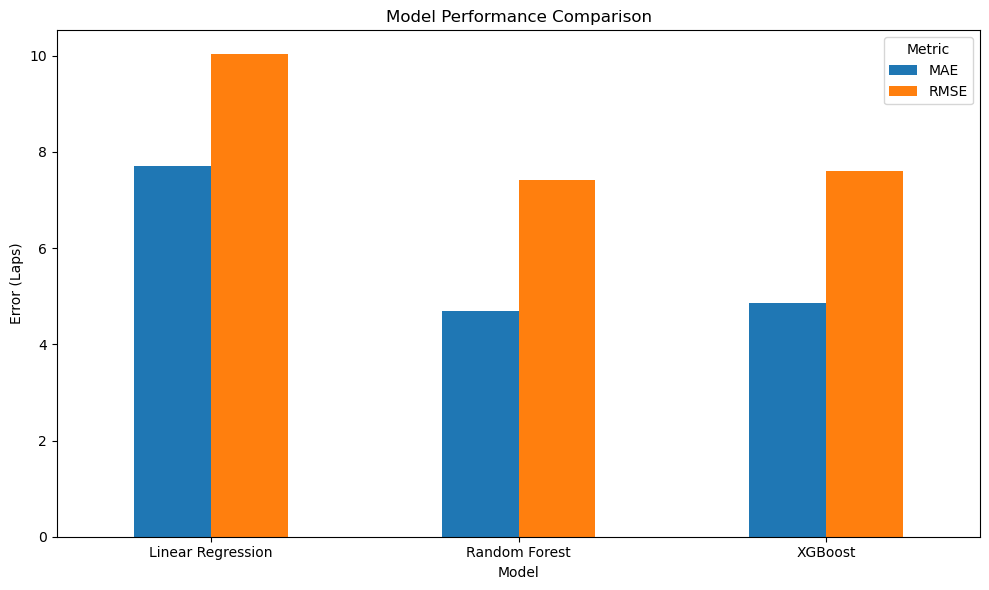

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
results_df[['MAE', 'RMSE']].plot(kind='bar', ax=ax)
ax.set_title('Model Performance Comparison')
ax.set_ylabel('Error (Laps)')
ax.set_xlabel('Model')
plt.xticks(rotation=0)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

## Step 8: Feature Importance

Analyze feature importance for the Random Forest model.

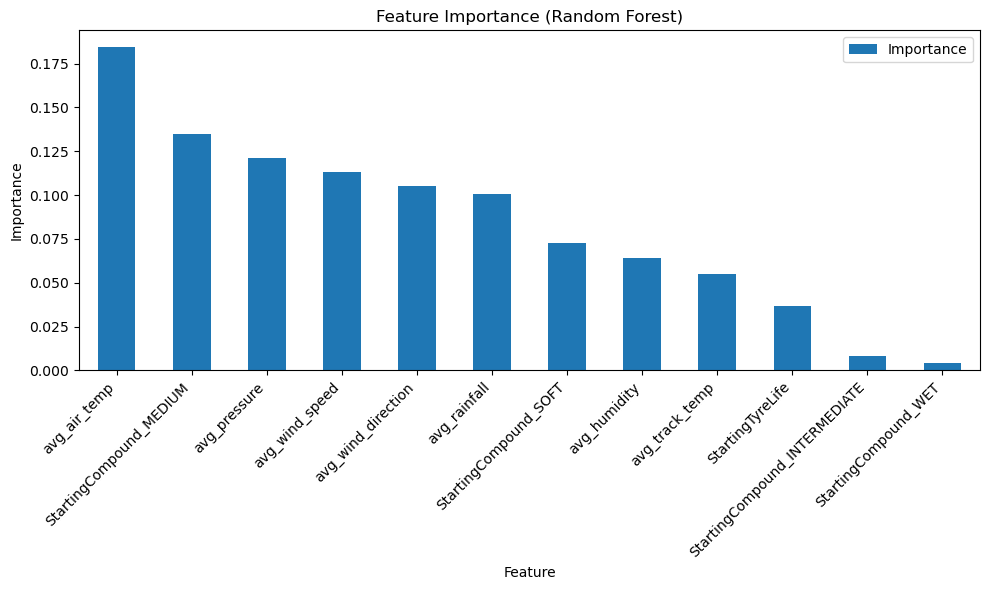

Feature Importance:
                           Feature  Importance
1                    avg_air_temp    0.184717
9         StartingCompound_MEDIUM    0.134643
3                    avg_pressure    0.120950
6                  avg_wind_speed    0.113316
7              avg_wind_direction    0.105347
4                    avg_rainfall    0.100362
10          StartingCompound_SOFT    0.072596
2                    avg_humidity    0.064003
5                  avg_track_temp    0.054763
0                StartingTyreLife    0.036565
8   StartingCompound_INTERMEDIATE    0.008346
11           StartingCompound_WET    0.004393


In [22]:
# Get feature importance for Random Forest
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', RandomForestRegressor(random_state=42))])
rf_pipeline.fit(X_train, y_train)
feature_names = (numerical_features + 
                 list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)))
importances = rf_pipeline.named_steps['model'].feature_importances_
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 6))
feature_importance_df.plot(x='Feature', y='Importance', kind='bar', ax=ax)
ax.set_title('Feature Importance (Random Forest)')
ax.set_ylabel('Importance')
ax.set_xlabel('Feature')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Feature Importance:\n", feature_importance_df)

In [23]:
import pandas as pd
import numpy as np
import glob
import os
import re

def extract_year_round_number(file_path):
    base_name = os.path.basename(file_path)
    match = re.search(r'(\d{4})_round_(\d+)_', base_name)
    if match:
        year = int(match.group(1))
        round_num = int(match.group(2))
        return year, round_num
    return None, None

laps_files = glob.glob('../data/2025/*_laps.csv')
laps_data_points = []
for laps_file in laps_files:
    year, round_number = extract_year_round_number(laps_file)
    if year is None or round_number is None:
        print(f"Could not extract year and round from {laps_file}")
        continue
    try:
        df = pd.read_csv(laps_file)
        df['Stint'] = pd.to_numeric(df['Stint'], errors='coerce').astype('Int64')
        df['TyreLife'] = pd.to_numeric(df['TyreLife'], errors='coerce')
    except Exception as e:
        print(f"Error reading {laps_file}: {e}")
        continue
    
    for driver, group in df.groupby('Driver'):
        try:
            stint1_lap1 = group[(group['LapNumber'] == 1) & (group['Stint'] == 1)]
            if stint1_lap1.empty:
                print(f"No lap 1 in stint 1 for driver {driver} in Round {round_number}")
                continue
            starting_compound = stint1_lap1['Compound'].iloc[0]
            starting_tyre_life = stint1_lap1['TyreLife'].iloc[0]
            if pd.isna(starting_tyre_life):
                print(f"Invalid TyreLife for driver {driver} in Round {round_number}")
                continue
            stint1 = group[group['Stint'] == 1]
            first_stint_length = stint1['LapNumber'].max()
            if pd.isna(first_stint_length):
                print(f"Invalid stint length for driver {driver} in Round {round_number}")
                continue
            laps_data_points.append({
                'Year': year,
                'RoundNumber': round_number,
                'Driver': driver,
                'StartingCompound': starting_compound,
                'StartingTyreLife': starting_tyre_life,
                'FirstStintLength': first_stint_length
            })
        except Exception as e:
            print(f"Error processing driver {driver} in Round {round_number}: {e}")
            continue

laps_df = pd.DataFrame(laps_data_points)

weather_files = glob.glob('../data/2025/*_weather.csv')
weather_results = []
for weather_file in weather_files:
    year, round_number = extract_year_round_number(weather_file)
    if year is None or round_number is None:
        print(f"Could not extract year and round from {weather_file}")
        continue
    try:
        df = pd.read_csv(weather_file)
        avg_air_temp = df['AirTemp'].mean()
        avg_humidity = df['Humidity'].mean()
        avg_pressure = df['Pressure'].mean()
        avg_rainfall = df['Rainfall'].mean()
        avg_track_temp = df['TrackTemp'].mean()
        # Circular mean for wind direction
        wind_dir_rad = np.radians(df['WindDirection'])
        avg_wind_direction = np.degrees(np.arctan2(np.sin(wind_dir_rad).mean(), np.cos(wind_dir_rad).mean()))
        avg_wind_speed = df['WindSpeed'].mean()
        weather_results.append({
            'Year': year,
            'RoundNumber': round_number,
            'avg_air_temp': avg_air_temp,
            'avg_humidity': avg_humidity,
            'avg_pressure': avg_pressure,
            'avg_rainfall': avg_rainfall,
            'avg_track_temp': avg_track_temp,
            'avg_wind_direction': avg_wind_direction,
            'avg_wind_speed': avg_wind_speed
        })
    except Exception as e:
        print(f"Error reading {weather_file}: {e}")
        continue

# Create DataFrame for weather data
weather_df = pd.DataFrame(weather_results)

# Merge laps and weather data
merged_2025_df = pd.merge(laps_df, weather_df, on=['Year', 'RoundNumber'], how='inner')

# Save merged data to CSV
merged_2025_df.to_csv('merged_2025_data.csv', index=False)
print("Merged 2025 data saved to 'merged_2025_data.csv'")

No lap 1 in stint 1 for driver ALB in Round 6
No lap 1 in stint 1 for driver ALO in Round 6
No lap 1 in stint 1 for driver ANT in Round 6
No lap 1 in stint 1 for driver BEA in Round 6
No lap 1 in stint 1 for driver BOR in Round 6
No lap 1 in stint 1 for driver GAS in Round 6
No lap 1 in stint 1 for driver HAD in Round 6
No lap 1 in stint 1 for driver HAM in Round 6
No lap 1 in stint 1 for driver HUL in Round 6
No lap 1 in stint 1 for driver LAW in Round 6
No lap 1 in stint 1 for driver LEC in Round 6
No lap 1 in stint 1 for driver NOR in Round 6
No lap 1 in stint 1 for driver OCO in Round 6
No lap 1 in stint 1 for driver PIA in Round 6
No lap 1 in stint 1 for driver RUS in Round 6
No lap 1 in stint 1 for driver SAI in Round 6
No lap 1 in stint 1 for driver STR in Round 6
No lap 1 in stint 1 for driver TSU in Round 6
No lap 1 in stint 1 for driver VER in Round 6
No lap 1 in stint 1 for driver LAW in Round 1
Merged 2025 data saved to 'merged_2025_data.csv'


In [24]:
# Load saved models
lr_pipeline = joblib.load('linear_regression_pipeline.joblib')
rf_pipeline = joblib.load('random_forest_pipeline.joblib')
xgb_pipeline = joblib.load('xgboost_pipeline.joblib')

In [25]:
df_2025 = pd.read_csv('merged_2025_data.csv')

features = ['StartingCompound', 'StartingTyreLife', 'avg_air_temp', 'avg_humidity', 
            'avg_pressure', 'avg_rainfall', 'avg_track_temp', 'avg_wind_speed', 'avg_wind_direction']
target = 'FirstStintLength'

X_2025 = df_2025[features]
y_2025 = df_2025[target]

lr_pred = lr_pipeline.predict(X_2025)
rf_pred = rf_pipeline.predict(X_2025)
xgb_pred = xgb_pipeline.predict(X_2025)

df_2025['lr_pred'] = lr_pred
df_2025['rf_pred'] = rf_pred
df_2025['xgb_pred'] = xgb_pred

print(df_2025[['Driver', 'RoundNumber', 'FirstStintLength', 'lr_pred', 'rf_pred', 'xgb_pred']].head())

  Driver  RoundNumber  FirstStintLength    lr_pred    rf_pred   xgb_pred
0    ALB            7              29.0  14.326576  19.972004  17.631256
1    ALO            7              12.0  13.328510  17.948475  13.844600
2    ANT            7              29.0  26.217244  33.824977  31.872227
3    BEA            7              29.0  26.217244  33.824977  31.872227
4    BOR            7              12.0  14.326576  19.972004  17.631256


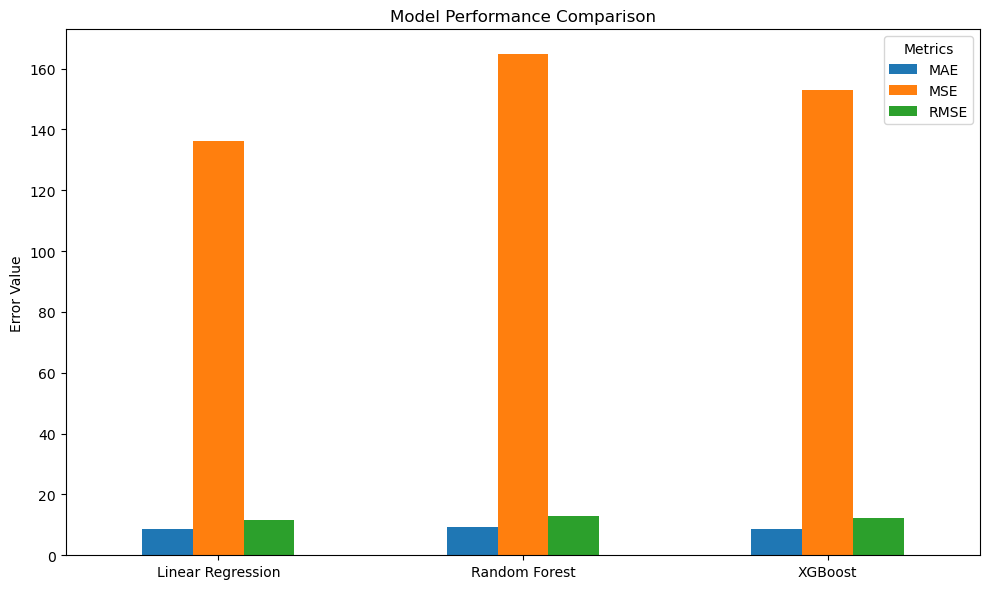

/var/folders/1f/z0fw8fgj5dn80_1mwsm3ssn00000gp/T/ipykernel_74906/3399274689.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(residuals.values(), labels=residuals.keys())


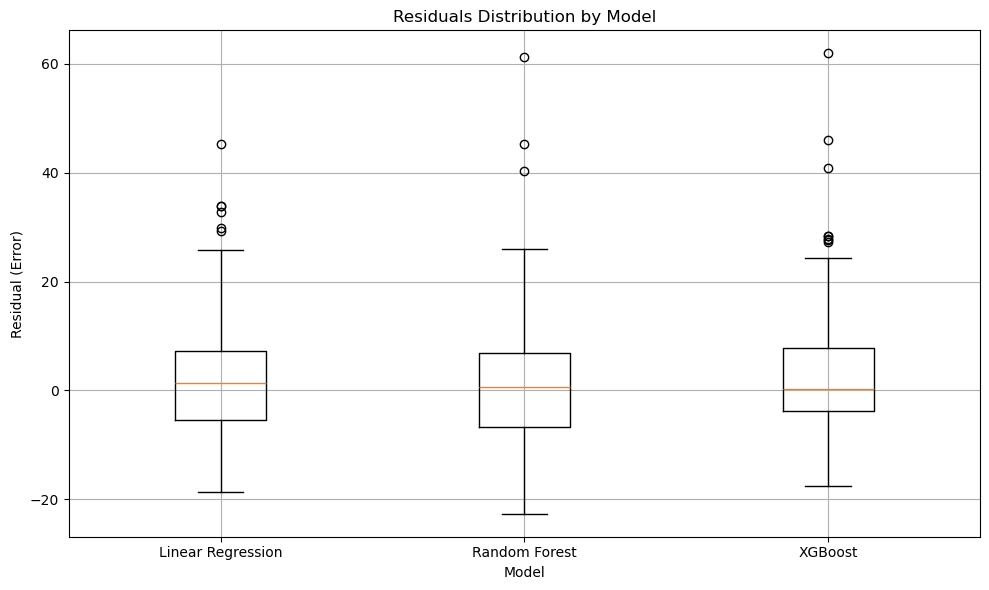

Error Metrics Table:
                         MAE         MSE       RMSE
Linear Regression  8.745448  136.138173  11.667826
Random Forest      9.423441  164.678962  12.832730
XGBoost            8.784280  152.846574  12.363113


In [26]:
df_2025['lr_residual'] = df_2025['FirstStintLength'] - df_2025['lr_pred']
df_2025['rf_residual'] = df_2025['FirstStintLength'] - df_2025['rf_pred']
df_2025['xgb_residual'] = df_2025['FirstStintLength'] - df_2025['xgb_pred']

# Step 2: Calculate error metrics
models = ['Linear Regression', 'Random Forest', 'XGBoost']
error_metrics = {}

for model in models:
    if model == 'Linear Regression':
        preds = df_2025['lr_pred']
    elif model == 'Random Forest':
        preds = df_2025['rf_pred']
    elif model == 'XGBoost':
        preds = df_2025['xgb_pred']
    
    actual = df_2025['FirstStintLength']
    mae = mean_absolute_error(actual, preds)
    mse = mean_squared_error(actual, preds)
    rmse = np.sqrt(mse)
    error_metrics[model] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse}

# Convert to DataFrame for plotting
error_df = pd.DataFrame(error_metrics).T

# Step 3: Bar plot for error metrics
plt.figure(figsize=(10, 6))
error_df.plot(kind='bar', ax=plt.gca())
plt.title('Model Performance Comparison')
plt.ylabel('Error Value')
plt.xticks(rotation=0)
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()

# Step 4: Box plot for residuals
residuals = {
    'Linear Regression': df_2025['lr_residual'],
    'Random Forest': df_2025['rf_residual'],
    'XGBoost': df_2025['xgb_residual']
}
plt.figure(figsize=(10, 6))
plt.boxplot(residuals.values(), labels=residuals.keys())
plt.title('Residuals Distribution by Model')
plt.ylabel('Residual (Error)')
plt.xlabel('Model')
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 5: Display error metrics table
print("Error Metrics Table:\n", error_df)

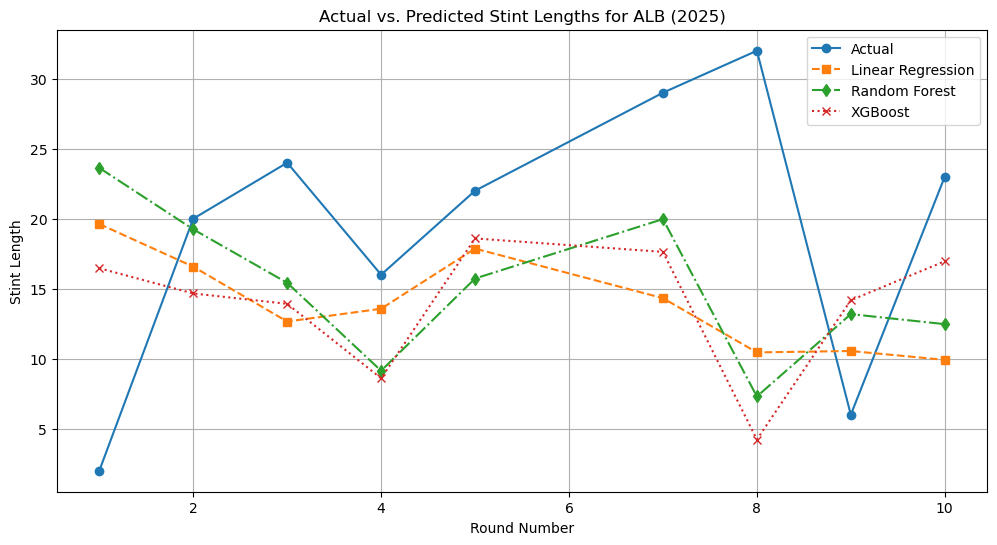

In [27]:
# Step 1: Load the 2025 data
df_2025 = pd.read_csv('merged_2025_data.csv')  # Adjust the filename as needed

# Step 2: Define the features used for prediction (must match training)
features = ['StartingCompound', 'StartingTyreLife', 'avg_air_temp', 'avg_humidity', 
            'avg_pressure', 'avg_rainfall', 'avg_track_temp', 'avg_wind_speed', 'avg_wind_direction']

# Step 3: Load the trained model pipelines
lr_pipeline = joblib.load('linear_regression_pipeline.joblib')
rf_pipeline = joblib.load('random_forest_pipeline.joblib')
xgb_pipeline = joblib.load('xgboost_pipeline.joblib')

# Step 4: Prepare the input data for prediction
X_2025 = df_2025[features]

# Step 5: Generate predictions
lr_pred = lr_pipeline.predict(X_2025)
rf_pred = rf_pipeline.predict(X_2025)
xgb_pred = xgb_pipeline.predict(X_2025)

# Step 6: Add predictions to the DataFrame
df_2025['lr_pred'] = lr_pred
df_2025['rf_pred'] = rf_pred
df_2025['xgb_pred'] = xgb_pred

# Step 7: Filter data for a specific driver and sort by round
driver = 'ALB'  # Replace with the correct driver code if 'ALB' isn’t in your data
driver_data = df_2025[df_2025['Driver'] == driver].sort_values('RoundNumber')

# Step 8: Plot the actual vs. predicted stint lengths
plt.figure(figsize=(12, 6))
plt.plot(driver_data['RoundNumber'], driver_data['FirstStintLength'], 'o-', label='Actual')
plt.plot(driver_data['RoundNumber'], driver_data['lr_pred'], 's--', label='Linear Regression')
plt.plot(driver_data['RoundNumber'], driver_data['rf_pred'], 'd-.', label='Random Forest')
plt.plot(driver_data['RoundNumber'], driver_data['xgb_pred'], 'x:', label='XGBoost')
plt.xlabel('Round Number')
plt.ylabel('Stint Length')
plt.title(f'Actual vs. Predicted Stint Lengths for {driver} (2025)')
plt.legend()
plt.grid(True)

## Step 9: Interpretation

The Random Forest model likely performs best due to its ability to capture non-linear relationships between features like tire compound and track temperature. The feature importance plot shows which factors (e.g., `StartingCompound`, `avg_track_temp`) most influence stint length. These insights can help teams optimize tire strategy based on weather conditions aste conditions and tire choice.